# Heterogeneous agent model in continuous time

This notebook replicates Achdou et al. (2020).

Open questions: 
- use sparse matrices
- use eigenvalues to compute g
    - take the one that corresponds to eigenvalue equal to 0
- Interpretation of transition matrix A compared to discrete time
    - not really transition, more an intensity matrix
- Transition dynamics

## Setup

In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import time

## HJB

### Explicit method

The intuition for the algorithm is simple. You want to solve for $v$ using the HJB equation in which we already took care of the optimization using the FOC. This is a fixed point involving $v$ and its derivative, which you approximate using finite differences. You can find the fixed point by iterating on a guess for $v$. 

You only need to be careful about 2 things: 
- when you approximate $v'$ you evaluate the derivative in the right direction (backward $v_{B}'$ versus forward $v_{F}'$)
- you take care of the borrowing constraint by making $v'$ take the right value if agents want to borrow at the constraint.

Given a guess for $v$, the algorithm works as follows. 

$\textbf{Step 1}$

Compute $v_{ij}'$ using 
$$
v_{ijF}' \equiv \frac{v_{i+1j} - v_{ij}}{\Delta a} \quad \text{and} \quad v_{ijB}' \equiv \frac{v_{ij} - v_{i-1j}}{\Delta a}
$$
and 
$$
v_{ij}' = \mathbb{1}\{ s_{ijF} > 0\} v_{ijF}' + \mathbb{1}\{ s_{ijB} < 0\} v_{ijB}' + \mathbb{1}\{ s_{ijF} \leq 0 \leq s_{ijB}\}u'(z_j + ra_i) 
$$

$\textbf{Step 2}$

Compute C using 
$$
c_{ij} = (u')^{-1}[v_{ij}']
$$

$\textbf{Step 3}$

Compute new $v$ from
$$
v_{ij}^{n+1} = v_{ij}^n + \Delta \left( u(c_{ij}^n) + (v_{ij}^n)'(z_j + ra_i - c_{ij}^n) + \lambda_j (v_{i-j}^n - v_{ij}^n) - \rho v_{ij}^n \right) 
$$

and compute distance between $v_{ij}^{n+1}$ and $v_{ij}^n$.

First define a bunch of parameters.

In [326]:
# interest rate - will be pinned down in GE
r = 0.035

# Economic parameters
s = 1.2                 # CRRA utility with parameter s
rho = 0.05              # discount rate
z1 = .1                 # income state 1   
z2 = .2                 # income state 2
z = [z1,z2]             # income sttes
la1 = 1.5               # intensity lambda_1
la2 = 1                 # intensity lambda_2
la = [la1,la2];         # intensity of Poisson process

# Computational parameters
I=1000                          # Size of asset grid
amin = -0.02                    # borrowing constraint
amax = 3                        # upper bound of grid
a = np.linspace(amin,amax,I)    # grid
da = (amax-amin)/(I-1)          # average distance on the grid
aa = np.tile(a,(2,1)).T
zz = np.ones((I,2))*z
maxit= 40000                    # max number of iterations
crit = 1e-6                     # tolerance for fixed point

# Initialize arrays
dVf = np.zeros((I,2))           # Forward derivative of value function
dVb = np.zeros((I,2))           # Backward derivative of value function
c = np.zeros((I,2))             # Consumption function

Then define one step of the iteration

In [327]:
def HJB_1step(v,r):

    # current guess
    V = v.copy()

    ## STEP 1
    
    # forward difference
    dVf[0:I-1,:] = (V[1:I,:]-V[0:I-1,:])/da
    dVf[I-1,:] = 1                              # will never be used anyway

    # backward difference
    dVb[1:I,:] = (V[1:I,:]-V[0:I-1,:])/da
    dVb[0,:] = (z + np.ones(2)*r*amin)**(-s)         # state constraint boundary condition

    #indicator whether value function is concave (problems arise if this is not the case)
    I_concave = dVb > dVf

    # consumption and savings with forward difference
    cf = dVf**(-1/s)
    muf = zz + r*aa - cf

    # consumption and savings with backward difference
    cb = dVb**(-1/s)
    mub = zz + r*aa - cb

    # consumption and derivative of value function at steady state (no savings)
    c0 = zz + r*aa;
    dV0 = c0**(-s)

    # dV_upwind makes a choice of forward or backward differences based on the sign of the drift    
    If = muf > 0                  # positive drift --> forward difference
    Ib = mub < 0                  # negative drift --> backward difference
    I0 = (1-If-Ib)                # at steady state (no savings)

    # make sure backward difference is used at amax
    Ib[I-1,:] = 1 
    If[I-1,:] = 0

    # Compute dv
    dV_Upwind = dVf*If + dVb*Ib + dV0*I0       # important to include third term

    ## STEP 2
    
    # Compute c
    c = dV_Upwind**(-1/s)
    
    ## STEP 3
    
    # Compute change in v
    V_switch = np.fliplr(V)
    Vchange = c**(1-s)/(1-s) + dV_Upwind*(zz + r*aa - c) + la*(V_switch - V) - rho*V

    # update guess
    Delta = .9*da/np.max(z2 + r*a)
    v = v + Delta*Vchange

    # compute distance
    d = np.max(np.abs(Vchange))
    
    return v,c,d

We can now iterate until we find the fixed point $v$

It = 5000; d = 1.14e-02
It = 10000; d = 9.05e-04
It = 15000; d = 9.70e-05
It = 20000; d = 1.04e-05
It = 25000; d = 1.12e-06
Time: 13.1 seconds


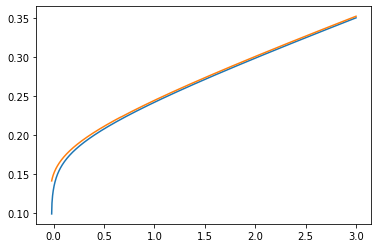

In [328]:
# initial guess
v = (zz + r*aa)**(1-s)/(1-s)/rho

t = time.time()
iter,d = 0,1
while (d > crit) & (iter < maxit): 
    
    iter += 1
    v,c,d = HJB_1step(v,r)
    if (iter % 5000 == 0): print(f'It = {iter}; d = {d:.2e}')
            
elapsed = time.time() - t
print(f'Time: {elapsed:.3} seconds')

# plot
plt.plot(a,c);

### Implicit method

The implicit method is similar except that $v$ is now updated using

$$
v_{ij}^{n+1} = v_{ij}^n + \Delta \left( u(c_{ij}^n) + (v_{ij}^{n+1})'(z_j + ra_i - c_{ij}^n) + \lambda_j (v_{i-j}^{n+1} - v_{ij}^{n+1}) - \rho v_{ij}^{n+1} \right) 
$$

Note that the HJB equation is just a fixed point for $v$, nothing tells you that you have to solve for it backward. In discrete time it makes sense intuitively and computationaly but here this is more open. In this case we mix things such that we can rearrange this equation in terms of some sort of transition matrix $A$. 

Given a guess for $v$, the algorithm works as follows. 

$\textbf{Step 1}$

Compute $v_{ij}'$ using 
$$
v_{ijF}' \equiv \frac{v_{i+1j} - v_{ij}}{\Delta a} \quad \text{and} \quad v_{ijB}' \equiv \frac{v_{ij} - v_{i-1j}}{\Delta a}
$$
and 
$$
v_{ij}' = \mathbb{1}\{ s_{ijF} > 0\} v_{ijF}' + \mathbb{1}\{ s_{ijB} < 0\} v_{ijB}' + \mathbb{1}\{ s_{ijF} \leq 0 \leq s_{ijB}\}u'(z_j + ra_i) 
$$

$\textbf{Step 2}$

Compute C using 
$$
c_{ij} = (u')^{-1}[v_{ij}']
$$

$\textbf{Step 3}$

Compute new $v$ by solving the system of linear equations
$$
\textbf{B}^n v^{n+1} = b^n \quad \text{where} \quad \textbf{B}^n = \left( \frac{1}{\Delta} + \rho \right) I - A^n, \quad b^n = u^n + \frac{1}{\Delta} v^n
$$

where $A$ is like a transition matrix encoding the evolution of exogenous and endogenous variables $(a,y)$.


In [460]:
# interest rate - will be pinned down in GE
r = 0.035

# Economic parameters
s = 1.2                 # CRRA utility with parameter s
rho = 0.05              # discount rate
z1 = .1                 # income state 1   
z2 = .2                 # income state 2
z = [z1,z2]             # income sttes
la1 = 1.5               # intensity lambda_1
la2 = 1                 # intensity lambda_2
la = [la1,la2];         # intensity of Poisson process
Bonds = 0.1

# Computational parameters
I=1000                          # Size of asset grid
amin = -0.02                    # borrowing constraint
amax = 3                        # upper bound of grid
a = np.linspace(amin,amax,I)    # grid
da = (amax-amin)/(I-1)          # average distance on the grid
aa = np.tile(a,(2,1)).T
zz = np.ones((I,2))*z
maxit= 100                      # max number of iterations
crit = 1e-6                     # tolerance for fixed point
Delta = 1000

# Initialize arrays
dVf = np.zeros((I,2))           # Forward derivative of value function
dVb = np.zeros((I,2))           # Backward derivative of value function
c = np.zeros((I,2))             # Consumption function
highpart = np.concatenate((-np.eye(I)*la[0],np.eye(I)*la[0]),1)
lowpart = np.concatenate((np.eye(I)*la[1],-np.eye(I)*la[1]),1)
Aswitch = np.concatenate((highpart,lowpart),0)

Then define one step of the iteration

In [461]:
def HJB_1step_implicit(v,r):

    # current guess
    V = v.copy()

    ## STEP 1

    # forward difference
    dVf[0:I-1,:] = (V[1:I,:]-V[0:I-1,:])/da
    dVf[I-1,:] = 1                              # will never be used anyway

    # backward difference
    dVb[1:I,:] = (V[1:I,:]-V[0:I-1,:])/da
    dVb[0,:] = (z + np.ones(2)*r*amin)**(-s)         # state constraint boundary condition

    #indicator whether value function is concave (problems arise if this is not the case)
    I_concave = dVb > dVf

    # consumption and savings with forward difference
    cf = dVf**(-1/s)
    ssf = zz + r*aa - cf

    # consumption and savings with backward difference
    cb = dVb**(-1/s)
    ssb = zz + r*aa - cb

    # consumption and derivative of value function at steady state (no savings)
    c0 = zz + r*aa;
    dV0 = c0**(-s)

    # dV_upwind makes a choice of forward or backward differences based on the sign of the drift    
    If = ssf > 0                  # positive drift --> forward difference
    Ib = ssb < 0                  # negative drift --> backward difference
    I0 = (1-If-Ib)                # at steady state (no savings)

    # make sure backward difference is used at amax
    Ib[I-1,:] = 1 
    If[I-1,:] = 0

    # Compute dv
    dV_Upwind = dVf*If + dVb*Ib + dV0*I0       # important to include third term

    ## STEP 2

    # Compute c
    c = dV_Upwind**(-1/s)
    u = c**(1-s)/(1-s)

    ## STEP 3

    # Construct matrix A and B
    X = - np.minimum(ssb,np.zeros((I,2)))/da
    Y = - np.maximum(ssf,np.zeros((I,2)))/da + np.minimum(ssb,np.zeros((I,2)))/da
    Z = np.maximum(ssf,np.zeros((I,2)))/da
    A1 = np.diag(Y[:,0],0) + np.diag(X[1:I,0],-1) + np.diag(Z[0:I-1,0],1)
    A2 = np.diag(Y[:,1],0) + np.diag(X[1:I,1],-1) + np.diag(Z[0:I-1,1],1)
    highpart = np.concatenate((A1,np.zeros((I,I))),1)
    lowpart = np.concatenate((np.zeros((I,I)),A2),1)
    A = np.concatenate((highpart,lowpart),0) + Aswitch
    B = (rho + 1/Delta)*np.eye(2*I) - A
    #B_sparse = scipy.sparse.dia_matrix(B)
    
    # Construct u and old V
    u_stacked = np.concatenate((u[:,0],u[:,1]),0)
    V_stacked = np.concatenate((V[:,0],V[:,1]),0) 

    # Solve system of equations
    b = u_stacked + V_stacked/Delta
    V_stacked = np.linalg.solve(B, b)
    #V_stacked = scipy.sparse.linalg.spsolve(B_sparse,b)         # no really faster with sparse matrix - need to turn everything into sparse matrices to make it work
    V[:,0] = V_stacked[0:I]
    V[:,1] = V_stacked[I:2*I]
    Vchange = V - v
    v = V

    # compute distance
    d = np.max(np.abs(Vchange))

    return v,c,d,A 


We now iterate until we find the fixed point

It = 2; d = 1.27e+00
It = 4; d = 3.84e-01
It = 6; d = 2.87e-03
It = 8; d = 1.03e-06
Time: 1.7 seconds


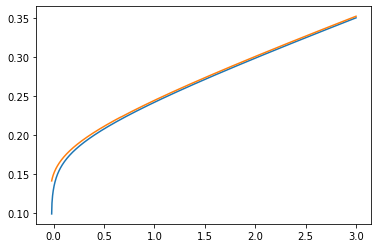

In [450]:
# initial guess
v = (zz + r*aa)**(1-s)/(1-s)/rho

t = time.time()
iter,d = 0,1
while (d > crit) & (iter < maxit): 
    
    iter += 1
    v,c,d,A = HJB_1step_implicit(v,r)
    if (iter % 2 == 0): print(f'It = {iter}; d = {d:.2e}')

elapsed = time.time() - t
print(f'Time: {elapsed:.2} seconds')

# plot
plt.plot(a,c);

The implicit method is 10 times faster than the explicit method, even using regular matrices.

## KFE

We now compute the stationary distribution by solving the system of equations

$$
0 = -[s_{ij}g_{ij}]' - \lambda_jg_{ij} - \lambda_{-j}g_{i-j}   \\
1 = \sum_{i=1}^I g_{i1} \Delta a + \sum_{i=1}^I g_{i2} \Delta a
$$

It turns out that one way to approximate this system of equations is to solve

$$
A^T g = 0
$$

where $A$ is the tranpose of the transition matrix computed before. This is very much like discrete time. You should also be able to compute the stationary distribution as the eigenvector corresponding to the largest eigenvalue of $A^T$.

In [462]:
def Dist_ss(A):
    
    AT = A.T
    b = np.zeros(2*I)

    # need to fix one value, otherwise matrix is singular
    b[0]=.1
    row = np.expand_dims(np.concatenate(([1],np.zeros((2*I-1)))),0)
    AT[0,:] = row

    # Solve linear system of equations
    gg = np.linalg.solve(AT, b)
    g_sum = np.sum(gg)*da
    gg = gg/g_sum
    g = np.concatenate((np.expand_dims(gg[0:I],0).T,np.expand_dims(gg[I:2*I],0).T),1)

    # mass for each income level
    check1 = g[:,0].T@np.ones((I,1))*da
    check2 = g[:,1].T@np.ones((I,1))*da
    if np.abs(check1[0]+check2[0]-1)>crit: print('Issue with distribution')

    return g
    

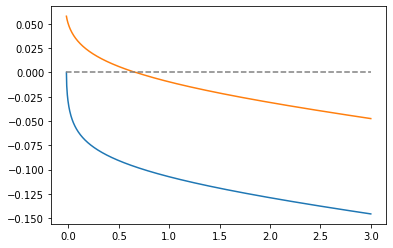

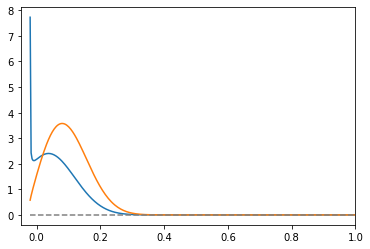

In [433]:
# solve for g
g = Dist_ss(A)

# plot with savings
adot = zz + r*aa - c
plt.plot(a,adot)
plt.plot(a,np.zeros((I,1)),'--',color='grey')

# plot with distribution
plt.figure()
plt.plot(a,g[:,0])
plt.plot(a,g[:,1])
plt.plot(a,np.zeros((I,1)),'--',color='grey')
plt.xlim([-0.05,1]);

## Steady state

We now solve for the interest rate $r$ such that the asset market clearing condition holds

$$
B = \sum_i^I a_i g_{i1} \Delta a + \sum_i^I a_i g_{i2} \Delta a
$$

We solve it by bijection.

In [470]:
rmin = 0.01
rmax = 0.04
Ir = 40;

# initial guess
v = (zz + r*aa)**(1-s)/(1-s)/rho

for ir in range(Ir):

    # solve for A
    iter,d = 0,1
    while (d > crit) & (iter < maxit): 
        iter += 1
        v,c,d,A = HJB_1step_implicit(v,r)
        if (iter % 100 == 0): print(f'It = {iter}; d = {d:.2e}')

    # solve for g
    g = Dist_ss(A)

    # Excess supply of assets
    S = g[:,0].T@a*da + g[:,1].T@a*da - Bonds

    # Update interest rate
    if S > crit:
        rmax = r
        r = 0.5*(r+rmin)
        print(f'Excess Supply, new r = {r:.5}')
    elif S < - crit:
        rmin = r
        r = 0.5*(r+rmax)
        print(f'Excess Demand, new r = {r:.5}')
    elif np.abs(S)<crit:
        print(f'Equilibrium Found, Interest rate = {r:.5}')
        break


Excess Demand, new r = 0.0375
Excess Demand, new r = 0.0388
Excess Supply, new r = 0.0381
Excess Supply, new r = 0.0378
Excess Demand, new r = 0.038
Excess Supply, new r = 0.0379
Excess Supply, new r = 0.0379
Excess Supply, new r = 0.0378
Excess Demand, new r = 0.0378
Excess Supply, new r = 0.0378
Excess Supply, new r = 0.0378
Excess Supply, new r = 0.0378
Excess Supply, new r = 0.0378
Equilibrium Found, Interest rate = 0.0378
